# ARIMA

In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data=pd.read_csv('https://raw.githubusercontent.com/McNickSisto/world_data_league/main/stage_final/data/Imputed_Data_Final.csv')
data=data.drop(columns='Unnamed: 0')
data.head(4)

,C1,C2,C3,C4,C5,date_hour,No. of Visitors,index,cluster,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),temp,winds,rainfall_mm,snowfall_mm,Holiday,isHoliday,date,hour,day,Log_Avg
0,68.7,56.6,76.0,58.8,66.6,2018-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,0.366667,-0.010,2.600000,New year's Day,1,2018-01-01,0,0,70.253908
1,68.3,53.4,68.2,55.4,65.4,2018-01-01 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,0.590000,0.009,2.600000,New year's Day,1,2018-01-01,1,0,65.415954
2,59.8,51.2,64.4,53.3,64.4,2018-01-01 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.05,0.450000,0.008,2.266667,New year's Day,1,2018-01-01,2,0,61.341179
3,67.4,47.2,67.5,48.4,61.8,2018-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.89,0.400000,0.006,2.266667,New year's Day,1,2018-01-01,3,0,64.066780


In [3]:
data_i = data.set_index('date_hour')
data_i.head(2)

,C1,C2,C3,C4,C5,No. of Visitors,index,cluster,data_a,numero_presenze,layer_id,layer_nome,dettaglio(secondi),temp,winds,rainfall_mm,snowfall_mm,Holiday,isHoliday,date,hour,day,Log_Avg
date_hour,,,,,,,,,,,,,,,,,,,,,,,
2018-01-01 00:00:00,68.7,56.6,76.0,58.8,66.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.04,0.366667,-0.010,2.6,New year's Day,1,2018-01-01,0,0,70.253908
2018-01-01 01:00:00,68.3,53.4,68.2,55.4,65.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.09,0.590000,0.009,2.6,New year's Day,1,2018-01-01,1,0,65.415954


In [4]:
df=data_i['Log_Avg']
df.head(2)

date_hour
2018-01-01 00:00:00    70.253908
2018-01-01 01:00:00    65.415954
Name: Log_Avg, dtype: float64

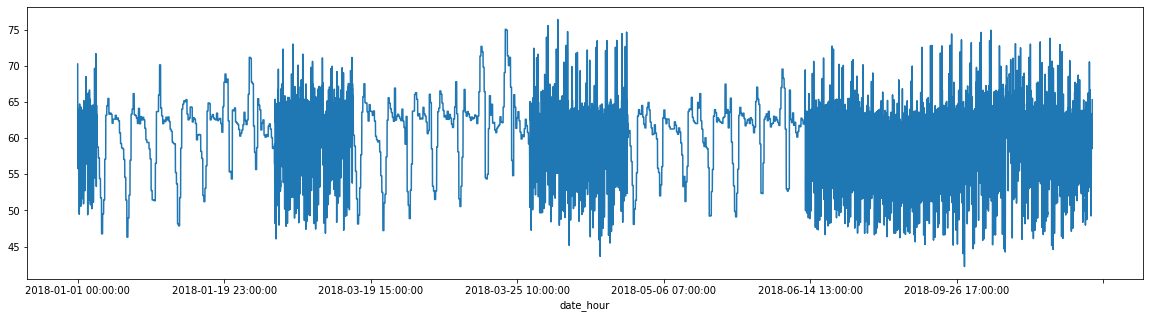

In [ ]:
df.plot(figsize=(20,5))

In [ ]:
additive = seasonal_decompose(df,freq=52, model='additive',extrapolate_trend='freq')

In [ ]:
additive_df = pd.concat([additive.seasonal, additive.trend, additive.resid, additive.observed], axis=1)
additive_df.columns = ['seasonal', 'trend', 'resid', 'actual_values']
additive_df.head()

,seasonal,trend,resid,actual_values
date_hour,,,,
2018-01-01 00:00:00,0.031040,59.533746,10.689122,70.253908
2018-01-01 01:00:00,0.101321,59.547141,5.767491,65.415954
2018-01-01 02:00:00,0.380611,59.560537,1.400032,61.341179
2018-01-01 03:00:00,0.190692,59.573932,4.302155,64.066780
2018-01-01 04:00:00,-0.067808,59.587328,3.655465,63.174985


Text(0.5, 0.98, 'Additive Decompose')

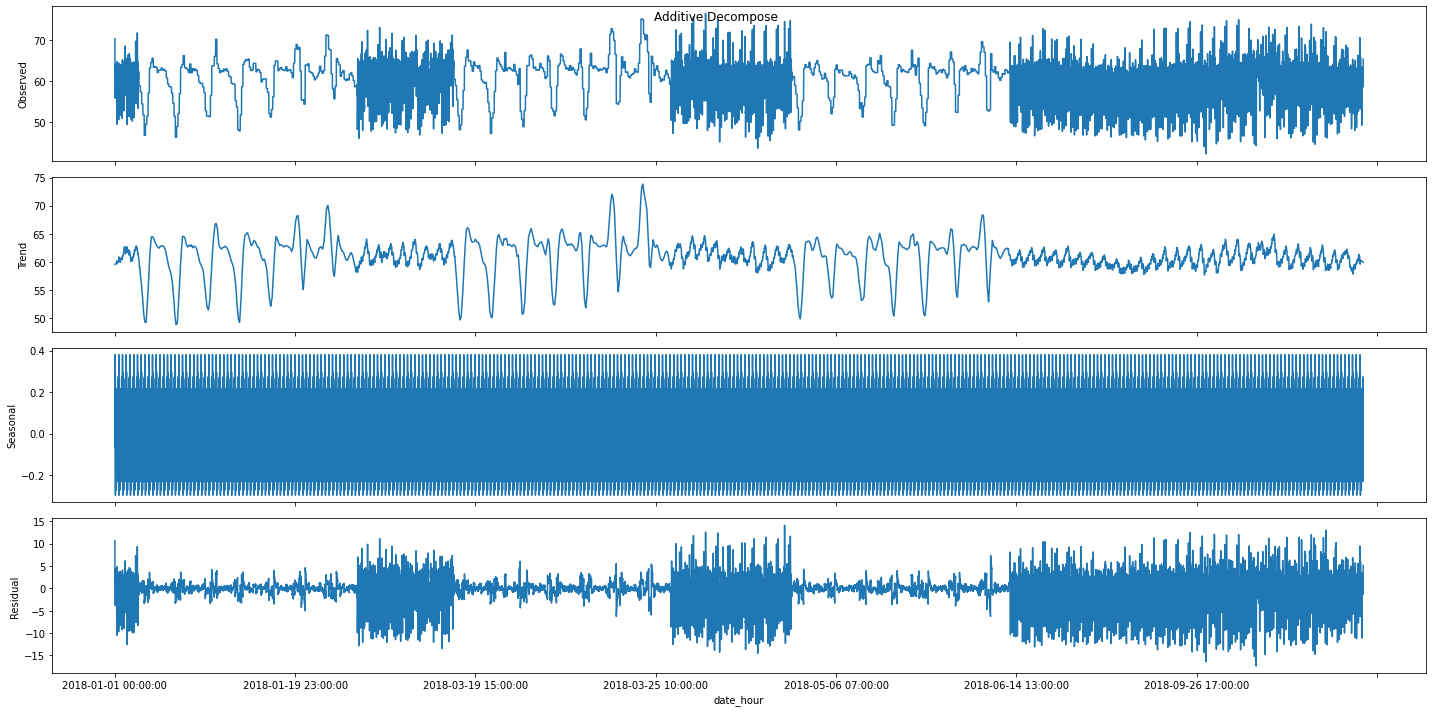

In [ ]:
plt.rcParams.update({'figure.figsize': (20,10)})
additive.plot().suptitle('Additive Decompose')
#The Trend,residuals are interesting, showing periods of high variability.

In [ ]:
trend = additive.trend
from statsmodels.tsa.stattools import adfuller
result = adfuller(trend.values)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -11.397865
p-value: 0.000000


Text(0.5, 0.98, '2nd Order Differencing')

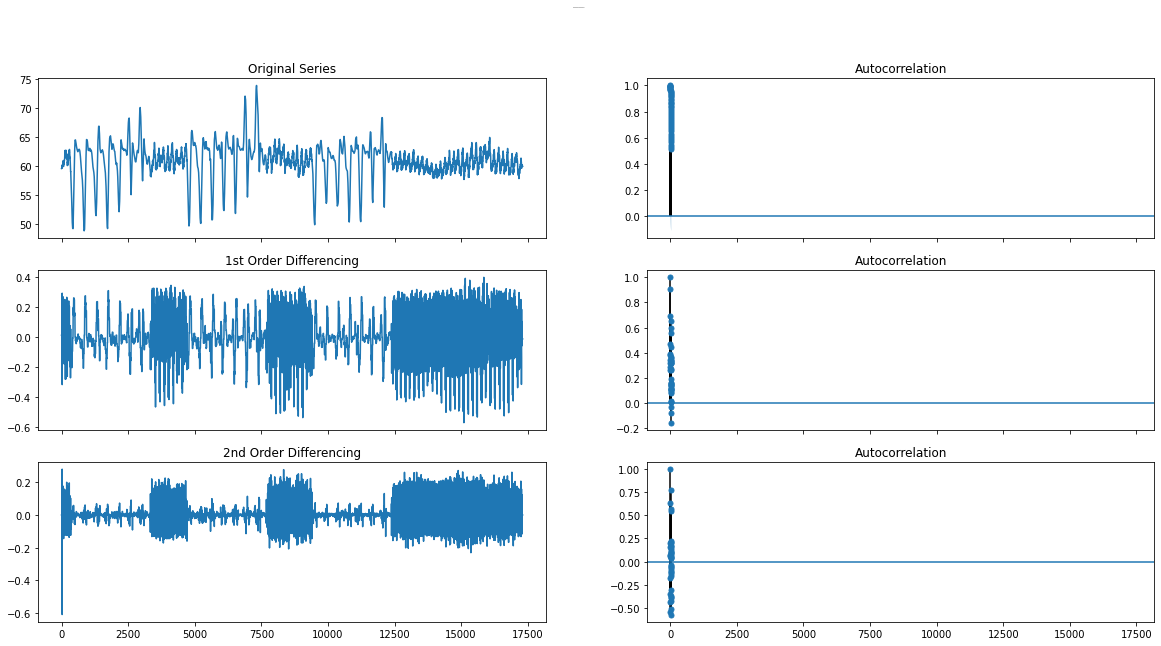

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(trend.values); axes[0, 0].set_title('Original Series')
plot_acf(trend.values, ax=axes[0, 1]).suptitle('Original Series', fontsize=0)
# 1st Differencing
diff1 = trend.diff().dropna()
axes[1, 0].plot(diff1.values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(diff1.values, ax=axes[1, 1]).suptitle('1st Order Differencing', fontsize=0)
# 2nd Differencing
diff2 = trend.diff().diff().dropna()
axes[2, 0].plot(diff2.values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(diff2.values, ax=axes[2, 1]).suptitle('2nd Order Differencing', fontsize=0)

Text(0.5, 0.98, '1st Order Differencing')

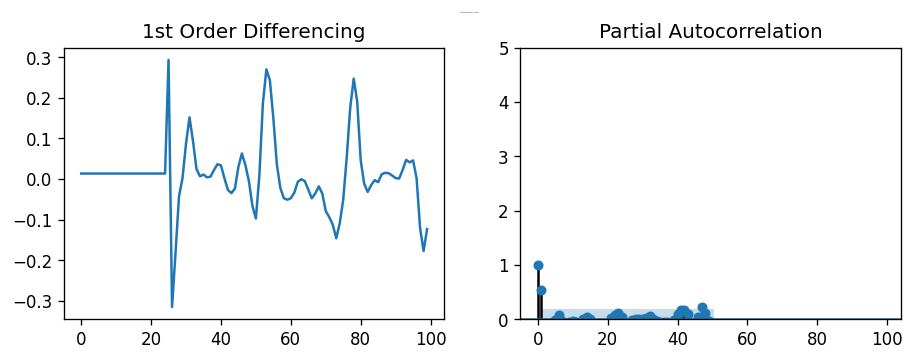

In [ ]:
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
size = 100
fig, axes = plt.subplots(1, 2, sharex=True)
axes[0].plot(diff1.values[:size])
axes[0].set_title('1st Order Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(diff1.values[:size], lags=50, ax=axes[1]).suptitle('1st Order Differencing', fontsize=0)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
train = trend[:3000]
test  = trend[3000:]
# order = (p=1, d=1, q=1)
model = ARIMA(train, order=(1, 1, 1))  
model = model.fit(disp=0)  
print(model.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:              D.Log_Avg   No. Observations:                 2999
Model:                 ARIMA(1, 1, 1)   Log Likelihood                6935.550
Method:                       css-mle   S.D. of innovations              0.024
Date:                Sat, 03 Jul 2021   AIC                         -13863.100
Time:                        13:19:47   BIC                         -13839.076
Sample:                             1   HQIC                        -13854.459
                                                                              
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               0.0003      0.013      0.023      0.982      -0.025       0.025
ar.L1.D.Log_Avg     0.9531      0.006    169.566      0.000       0.942       0.964
ma.L1.D.Log_Avg     0.3680      

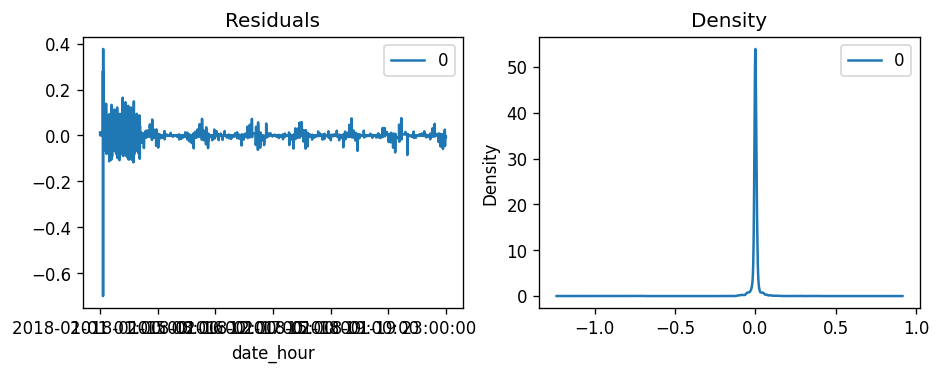

In [ ]:
# Plot residual errors
residuals = pd.DataFrame(model.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])

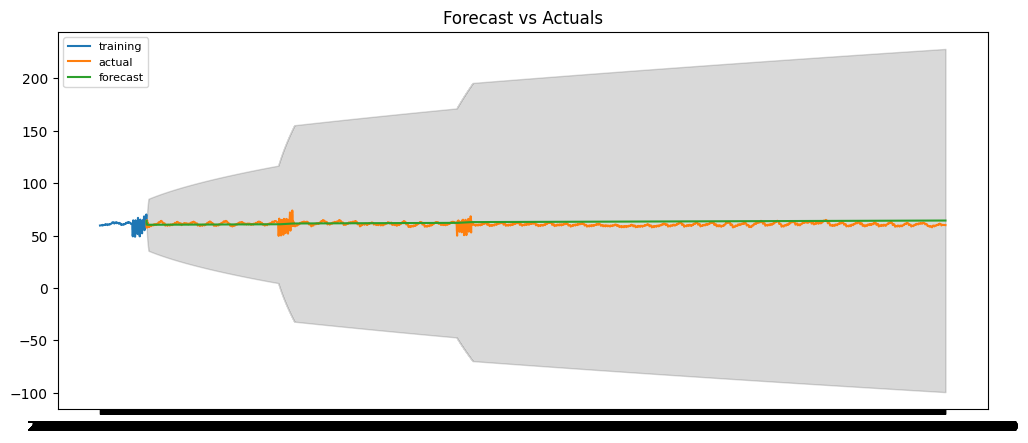

In [ ]:
fc, se, conf = model.forecast(14311, alpha=0.05)
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)

# Moving Average

In [5]:
df.head(2)

date_hour
2018-01-01 00:00:00    70.253908
2018-01-01 01:00:00    65.415954
Name: Log_Avg, dtype: float64

Moving Average Smoothing is a technique applied to time series to remove the fine-grained variation between time steps. The hope of smoothing is to remove noise and better expose the signal of the underlying causal processes.

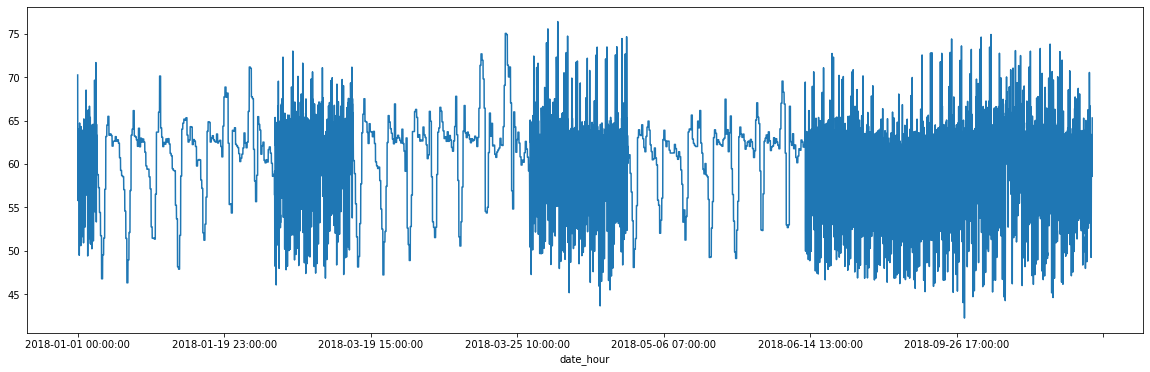

In [8]:
from pandas import read_csv
from matplotlib import pyplot
plt.rcParams["figure.figsize"] = (20,6)
df.plot()
pyplot.show()

date_hour
2018-01-01 02:00:00    65.670347
2018-01-01 03:00:00    63.607971
2018-01-01 04:00:00    62.860982
2018-01-01 05:00:00    61.009236
2018-01-01 06:00:00    58.338946
Name: Log_Avg, dtype: float64


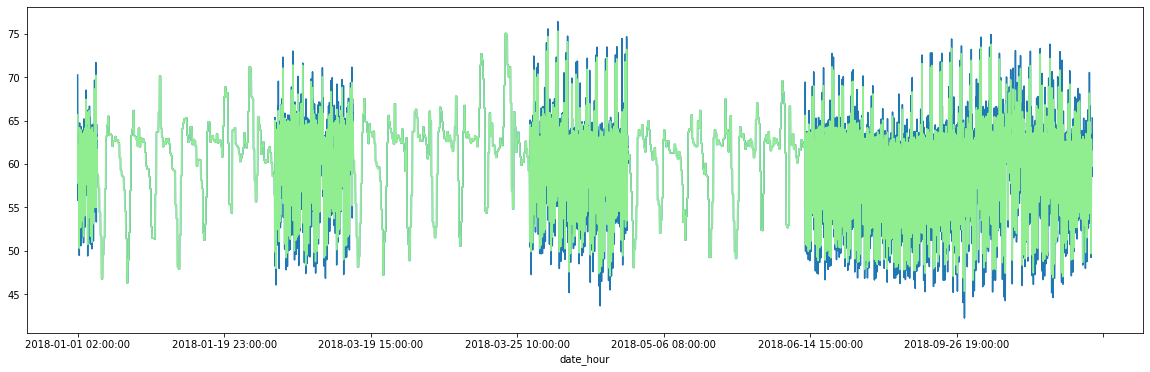

In [17]:
# Tail-rolling average transform
rolling = df.rolling(window=3)
rolling_mean = rolling.mean()
rolling_mean.dropna(inplace= True)
print(rolling_mean.head())
# plot original and transformed dataset
df.plot()
rolling_mean.plot(color='lightgreen')
pyplot.show()

Test MSE: 8.801


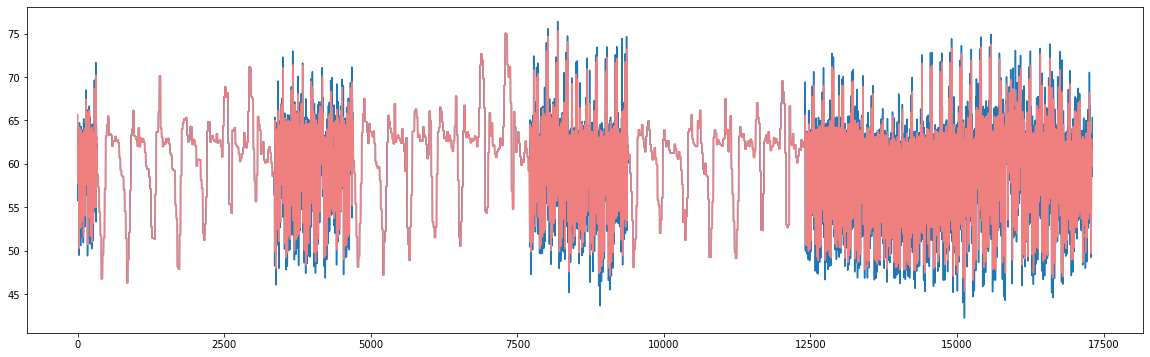

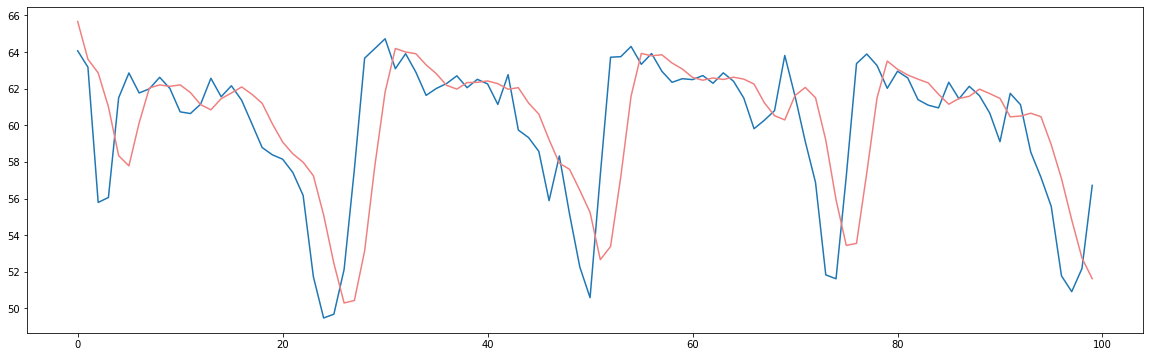

In [23]:
from pandas import read_csv
from numpy import mean
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
# prepare situation
X = df.values
window = 3
history = [X[i] for i in range(window)]
test = [X[i] for i in range(window, len(X))]
predictions = list()
# walk forward over time steps in test
for t in range(len(test)):
	length = len(history)
	yhat = mean([history[i] for i in range(length-window,length)])
	obs = test[t]
	predictions.append(yhat)
	history.append(obs)
	#print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot
pyplot.plot(test)
pyplot.plot(predictions, color='lightcoral')
pyplot.show()
# zoom plot
pyplot.plot(test[0:100])
pyplot.plot(predictions[0:100], color='lightcoral')
pyplot.show()